# Getting Started with Opart; GPU memory-efficient Emission Spectrum

Last update: January 14th (2025) Hajime Kawahara 

This is a device memory efficient version of [Getting Started with Simulating the Emission Spectra](get_started.html)!  

Note: It is worth noting that batch execution of this notebook (`jupyter nbconvert --to script get_started_opart.ipynb; python get_started_opart.py`) was successfully performed on a laptop equipped with an RTX 3080 (8GB device memory).　The device memory usage was approximately 2.4 GB.


First, we recommend 64-bit if you do not think about numerical errors. Use jax.config to set 64-bit. 
(But note that 32-bit is sufficient in most cases. Consider to use 32-bit (faster, less device memory) for your real use case.) 

In [1]:
#if you wanna monitor the device memory use, you can use jax_smi
#from jax_smi import initialise_tracking
#initialise_tracking()

In [2]:
from jax import config
config.update("jax_enable_x64", True)

One approach to reducing device memory usage is to calculate the opacity layer by layer and advance the radiative transfer by one layer at a time. To achieve this, it is necessary to integrate the opacity calculator (`opa`) and the radiative transfer (`art`), leading to the use of the `opart` class (opa + art). Here, we demonstrate the calculation of a pure absorption emission spectrum using `opart`.

## 1. Computes an Emission Spectrum using `opart`

The user needs to define a class, `OpaLayer`, that specifies how to calculate opacity for each layer. The `OpaLayer` class must define at least an `__init__` method and a `__call__` method. Additionally, `self.nu_grid` must be defined. In this example, molecular absorption by CO and the CIA continuum opacity of H2 are defined for each layer. The `__call__` method should take the parameters of a layer as input and return the optical depth (delta tau) for that layer.

Note that you can also use the [nu-stitching](Cross_Section_using_OpaStitch.html) option in `OpaPremodit` if you want to cut the wing.

In [ ]:
from exojax.database.api  import MdbExomol
from exojax.database.contdb  import CdbCIA
from exojax.opacity import OpaPremodit
from exojax.opacity import OpaCIA
from exojax.rt.layeropacity import single_layer_optical_depth
from exojax.rt.layeropacity import single_layer_optical_depth_CIA
from exojax.utils.grids import wavenumber_grid
from exojax.utils.astrofunc import gravity_jupiter


class OpaLayer:
    # user defined class, needs to define self.nugrid
    def __init__(self, Nnus=150000):
        self.nu_grid, self.wav, self.resolution = wavenumber_grid(
            1950.0, 2250.0, Nnus, unit="cm-1", xsmode="premodit"
        )
        # sets mdb for CO
        self.mdb_co = MdbExomol(".database/CO/12C-16O/Li2015", nurange=self.nu_grid)
        self.opa_co = OpaPremodit(
            self.mdb_co,
            self.nu_grid,
            auto_trange=[500.0, 1500.0],
            dit_grid_resolution=1.0,
            #nstitch=10, # nu-stitch option
            #cutwing=0.015, #nu-stitch option
            allow_32bit=True
        )
        # sets CIA
        self.cdb_cia = CdbCIA(".database/H2-H2_2011.cia",nurange=self.nu_grid)
        self.opa_cia = OpaCIA(self.cdb_cia, nu_grid=self.nu_grid)
        # other parameters (optiohal)        
        self.gravity = gravity_jupiter(1.0, 10.0)
        self.vmrH2 = 0.855 # VMR for H2
        self.mmw = 2.33 # mean molecular weight of the atmosphere

    def __call__(self, params):
        temperature, pressure, dP, mixing_ratio = params
        # computes CO opacity
        xsv_co = self.opa_co.xsvector(temperature, pressure)
        dtau_co = single_layer_optical_depth(
            dP, xsv_co, mixing_ratio, self.mdb_co.molmass, self.gravity
        )
        # computes CIA opacity
        logacia_vector = self.opa_cia.logacia_vector(temperature)
        dtau_cia = single_layer_optical_depth_CIA(temperature, pressure, dP, self.vmrH2, self.vmrH2, self.mmw, self.gravity, logacia_vector)
        return dtau_co + dtau_cia

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


For molecular opacity, note that the opacity for a single layer is calculated here. First, `opa.xsvector` (the cross-section vector along the wavenumber direction) is computed, and then it is converted into the optical depth for a single layer using [spec.layeropacity.single_layer_optical_depth](../exojax/exojax.spec.html#exojax.spec.layeropacity.single_layer_optical_depth).

In the code above, CIA is assumed as the continuum, and [spec.layeropacity.single_layer_optical_depth_CIA](../exojax/exojax.spec.html#exojax.spec.layeropacity.single_layer_optical_depth_CIA) is used. However, other options such as [spec.layeropacity.single_layer_optical_depth_Hminus](../exojax/exojax.spec.html#exojax.spec.layeropacity.single_layer_optical_depth_Hminus) for H-, for example.

For Rayleigh scattering, [spec.rayleigh.xsvector_rayleigh_gas](../exojax/exojax.spec.html#exojax.spec.rayleigh.xsvector_rayleigh_gas) provides the cross-section vector (a vector of cross-sections along the wavenumber direction), so you can use [spec.layeropacity.single_layer_optical_depth](../exojax/exojax.spec.html#exojax.spec.layeropacity.single_layer_optical_depth) in the same way as for molecules.

Do not put  `@partial(jit, static_argnums=(0,))` on ``__call__``.  This is not necessary and makes the code significantly slow.

Next, the user will utilize the `OpaLayer` class in the `Opart` class. Here, since the goal is to calculate pure absorption emission, the `OpartEmisPure` class will be used. (Remember that if `opa` and `art` are separated, the `ArtEmisPure` class would have been used instead.)

In [4]:
from exojax.rt.opart import OpartEmisPure

opalayer = OpaLayer(Nnus=150000)
opart = OpartEmisPure(opalayer, pressure_top=1.0e-5, pressure_btm=1.0e1, nlayer=200, nstream=8)
opart.change_temperature_range(400.0, 1500.0)


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
HITRAN exact name= (12C)(16O)
radis engine =  vaex


/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadening code level: a0


/home/kawahara/anaconda3/lib/python3.10/site-packages/radis-0.15.2-py3.10.egg/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/opacalc.py:215: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1514.171191195336 K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K
# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 0it [00:00, ?it/s]

Premodit: Twt= 1108.7151960064205 K Tref= 570.4914318566549 K
Making LSD:|####################| 100%


H2-H2


Here, somewhat abruptly, we define a function to update a layer. This function simply calls `update_layer` within `opart` and returns its output along with `None`. You might wonder why you need to define such a function yourself. To get a bit technical, this function is used with `jax.lax.scan` when updating layers. However, if it is defined inside a class, XLA will recompile every time the parameters change, leading to a performance slowdown. For this reason, in the current implementation, users are required to define this function outside the class. This implementation may be revisited and revised in the future.

In [5]:
def layer_update_function(carry_tauflux, params):
    carry_tauflux = opart.update_layer(carry_tauflux, params)
    return carry_tauflux, None

Now, let’s define the temperature and mixing ratio profiles (in the same way as for `art`) and calculate the flux. Define the `layer_parameter` input, which is a list of parameters for all layers. The temperature profile must be specified as the first element (index 0). For the remaining elements, arrange them in the same order as used in the user-defined `OpaLayer`.

In [6]:
temperature = opart.clip_temperature(opart.powerlaw_temperature(900.0, 0.1))
mixing_ratio = opart.constant_mmr_profile(0.00001)
layer_params = [temperature, opart.pressure, opart.dParr, mixing_ratio]
flux = opart(layer_params, layer_update_function)

The spectrum has now been calculated. Let’s plot it. In this example, we calculate 200,000 wavenumber grid points across 200 layers. Even if the GPU you’re using has only 8 GB of device memory, such as an RTX 2080, it should be sufficient to perform the computation.

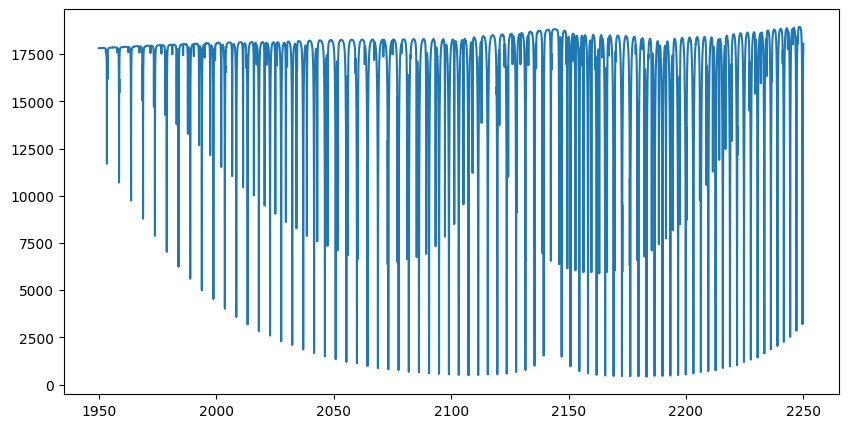

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(opalayer.nu_grid, flux)
plt.show()    

## 2. Optimization of `opart` using Forward-mode Differentiation

Next, we will perform gradient-based optimization using `opart`. First, let's generate mock data.

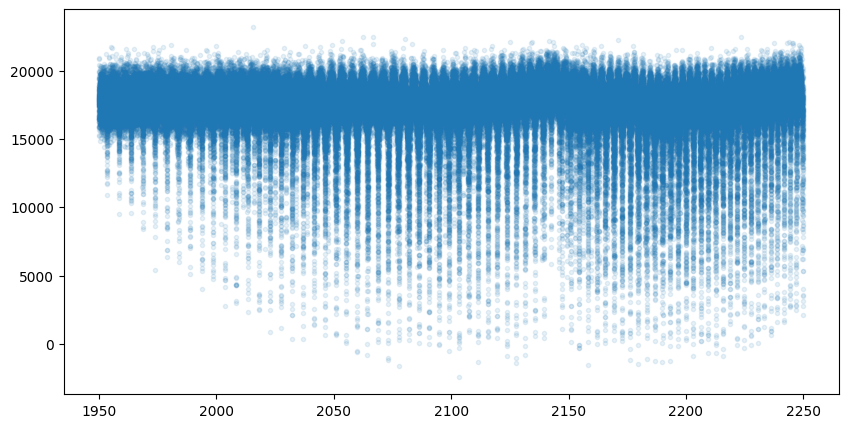

In [8]:
import numpy as np
import matplotlib.pyplot as plt
mock_spectrum = flux +  np.random.normal(0.0, 1000.0, len(opalayer.nu_grid))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(opalayer.nu_grid, mock_spectrum, ".", alpha=0.1)
#plt.plot(opalayer.nu_grid, flux, lw=1, color="red")

plt.show()    

Next, define the objective function.

In this example, we will optimize two parameters of the temperature profile (T0 and powerlaw index alpha). For gradient-based optimization, we need to compute gradients. Typically, gradients are calculated using `jax.grad`, which employs reverse-mode differentiation. However, this approach consumes a significant amount of memory. Instead, we use forward-mode differentiation. 

The differences between forward-mode and reverse-mode differentiation can be summarized as shown in the figure below.
In forward-mode differentiation, function composition and differentiation propagate from the input side (left) to the output side (right), allowing function values and derivative values at each step to be discarded from memory. Each step of computation uses the Jacobian-Vector Product (JVP; directional derivative itself).

On the other hand, in reverse-mode differentiation (also known as backpropagation), differentiation proceeds from the output side (right) to the input side (left). Each step uses the Vector-Jacobian Product (VJP), but computing the VJP requires function values after updates (denoted as $f({\bf \omega})$) in the figure. Therefore, the function must first be composed from the input side to the output side, and intermediate results must be stored. This leads to higher (device) memory usage.

The advantage of reverse-mode differentiation is that when the input vector has a higher dimension than the output vector (e.g., when the output is a single cost function), its computational cost is lower than that of forward-mode differentiation. In typical retrieval scenarios, this advantage is not very significant. However, when the number of estimated parameters is large, it can become a critical issue, so careful consideration of the memory-computation tradeoff is recommended.

![Figure forward-mode and reverse-mode differentiation](https://secondearths.sakura.ne.jp/exojax/figures/exojax_fr.png)

For this purpose, we utilize `jax.jacfwd` as the Jacobian computation using the forward-mode.

In [9]:
import jax.numpy as jnp
fac = 1.e4


def objective_fluxt_vector(params):
    T = params[0]*fac
    alpha = params[1]
    temperature = opart.clip_temperature(opart.powerlaw_temperature(T, alpha))
    mixing_ratio = opart.constant_mmr_profile(0.00001)
    layer_params = [temperature, opart.pressure, opart.dParr, mixing_ratio]
    flux = opart(layer_params , layer_update_function) 
    res = flux - mock_spectrum
    return jnp.dot(res,res)*1.0e-12

from jax import jacfwd

def dfluxt_jacfwd(params):
    return jacfwd(objective_fluxt_vector)(params)

print(dfluxt_jacfwd([900.0/fac, 0.1]))


[Array(-0.30389497, dtype=float64), Array(-0.03122399, dtype=float64)]


Or  alternatively `jax.jvp` (Jacobian-Vector Product) can be used.　Using `jax.jvp` might be slightly slower than `jacfwd`, but...

In [24]:

import jax.numpy as jnp

def objective_fluxt_each(T0,alpha):
    temperature = opart.clip_temperature(opart.powerlaw_temperature(T0, alpha))
    mixing_ratio = opart.constant_mmr_profile(0.00001)
    layer_params = [temperature, opart.pressure, opart.dParr, mixing_ratio]
    flux = opart(layer_params , layer_update_function) 
    res = flux - mock_spectrum
    return jnp.dot(res,res)*1.0e-12


from jax import jvp
fac = 1.e4

def dfluxt_jvp(params):
    T = params[0]*fac
    alpha = params[1]
    return jnp.array([jvp(objective_fluxt_each, (T,alpha), (1.0,0.0))[1], jvp(objective_fluxt_each, (T,alpha), (0.0,1.0))[1]])

print(dfluxt_jvp([900.0/fac, 0.1]))



[-8.83467787e-06 -4.74474356e-03]


Let’s plot the objective function as a function of T.

In [10]:
method = "jacfwd" # "jvp" for the jvp case

import tqdm
obj = []
derivative = [] 
tlist = np.linspace(800.0, 1000.0, 50)/fac
for t in tqdm.tqdm(tlist):
    if method == "jacfwd":
        params = jnp.array([t, 0.1])
        value = objective_fluxt_vector(params) #jacfwd case
        df = dfluxt_jacfwd(params)
    elif method == "jvp":
        value = objective_fluxt_each(t*fac, 0.1) #jvp case
        df = dfluxt_jvp([t, 0.1]) #jvp case
    obj.append(value)
    derivative.append(df[0])


100%|██████████| 50/50 [10:21<00:00, 12.44s/it]


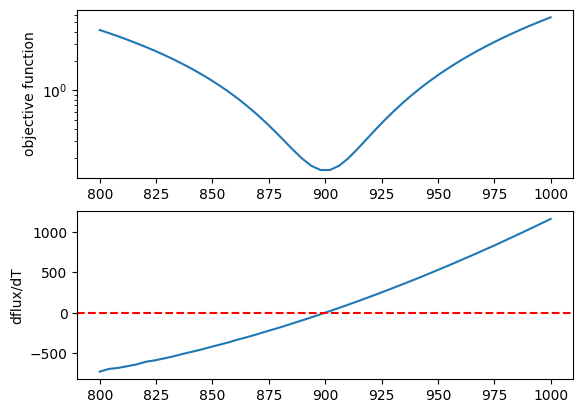

In [11]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.plot(tlist*fac, obj)
plt.yscale("log")
plt.ylabel("objective function")
ax = fig.add_subplot(212)
plt.plot(tlist*fac, derivative)
plt.axhline(0.0, color="red", linestyle="--")
plt.ylabel("dflux/dT")
plt.show()


Let's perform optimization using the gradient (JVP) with [optax](https://github.com/google-deepmind/optax)'s AdamW optimizer (you can, of course, use Adam or other optimizers if preferred).

In [31]:
import optax
solver = optax.adamw(learning_rate=0.01)
params = jnp.array([800.0/fac, 0.08])
opt_state = solver.init(params)


trajectory=[]
for i in range(100):
    grad = dfluxt_jacfwd(params)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    trajectory.append(params)
    if np.mod(i,10)==0:    
        print('Objective function: {:.2E}'.format(objective_fluxt_vector(params)), "T0: ", params[0]*fac, "alpha: ", params[1])

Objective function: 1.99E-01 T0:  899.9991999987783 alpha:  0.08999991999873427
Objective function: 3.48E-01 T0:  926.6781692992693 alpha:  0.0931724823153698
Objective function: 1.68E-01 T0:  901.8653101013599 alpha:  0.09225547157640661
Objective function: 2.08E-01 T0:  895.2651875787137 alpha:  0.0935864758062235
Objective function: 1.81E-01 T0:  896.1425462222461 alpha:  0.09567910622999228
Objective function: 1.59E-01 T0:  897.9766116513349 alpha:  0.09752100457624553
Objective function: 1.50E-01 T0:  899.7120460192209 alpha:  0.09889100848017918
Objective function: 1.49E-01 T0:  900.9991516321255 alpha:  0.0997522033521371
Objective function: 1.50E-01 T0:  901.1835152084095 alpha:  0.10013304971008916
Objective function: 1.49E-01 T0:  900.2631301037181 alpha:  0.10015558983532892


Plots the optimization trajectory

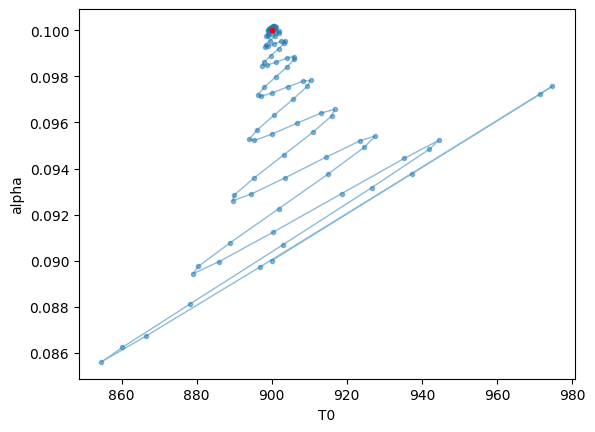

In [39]:
trajectory = jnp.array(trajectory)
import matplotlib.pyplot as plt
plt.plot(trajectory[:,0]*fac, trajectory[:,1],".",alpha=0.5,lw=1, color="C0")
plt.plot(trajectory[:,0]*fac, trajectory[:,1],alpha=0.5,lw=1, color="C0")
plt.plot(900.0,0.1,".",color="red")
plt.xlabel("T0")
plt.ylabel("alpha")
plt.show()

Let's compare the model using the best-fit values with the mock data.

In [40]:
def fluxt(T0, alpha):
    temperature = opart.clip_temperature(opart.powerlaw_temperature(T0, alpha))
    mixing_ratio = opart.constant_mmr_profile(0.00001)
    layer_params = [temperature, opart.pressure, opart.dParr, mixing_ratio]
    flux = opart(layer_params , layer_update_function) 
    return flux


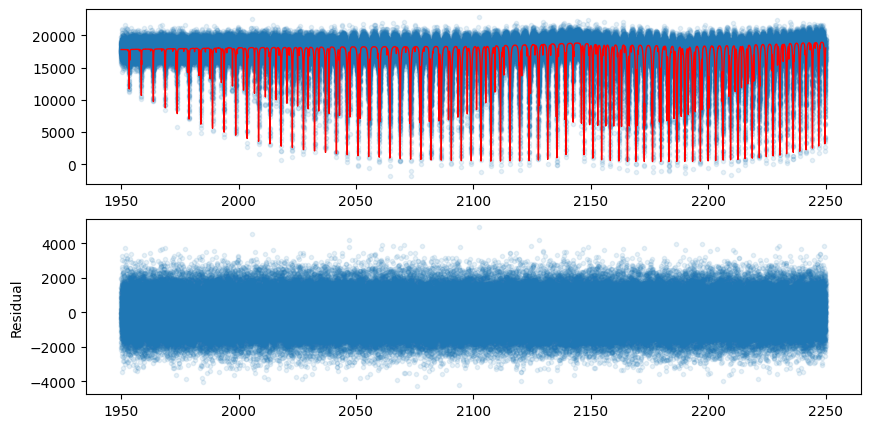

In [41]:
import numpy as np
mock_spectrum = flux +  np.random.normal(0.0, 1000.0, len(opalayer.nu_grid))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(211)
plt.plot(opalayer.nu_grid, mock_spectrum, ".", alpha=0.1)
plt.plot(opalayer.nu_grid, fluxt(params[0]*fac, params[1]), lw=1, color="red")
ax = fig.add_subplot(212)
plt.plot(opalayer.nu_grid, mock_spectrum-fluxt(params[0]*fac, params[1]), ".", alpha=0.1)
plt.ylabel("Residual")
plt.show()    

In this way, gradient optimization can be performed in a device memory-efficient manner using forward differentiation.

## 3. HMC-NUTS using forward differentiation

Forward differentiation must also be used in HMC-NUTS. In NumPyro's NUTS, this can be achieved by setting the option `forward_mode_differentiation=True`. Other than this, the execution method is the same as the standard HMC-NUTS.

In [42]:
def fluxt(T0, alpha):
    temperature = opart.clip_temperature(opart.powerlaw_temperature(T0, alpha))
    mixing_ratio = opart.constant_mmr_profile(0.00001)
    layer_params = [temperature, opart.pressure, opart.dParr, mixing_ratio]
    flux = opart(layer_params , layer_update_function) 
    return flux


In [43]:
#PPL import
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from jax import random

In [44]:
def model_c(y1):
    T0 = numpyro.sample('T0', dist.Uniform(800.0, 1000.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.05, 0.15))
    mu =  fluxt(T0, alpha)
    sigmain = numpyro.sample('sigmain', dist.Exponential(0.001))
    numpyro.sample('y1', dist.Normal(mu, sigmain), obs=y1)



In [45]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200
kernel = NUTS(model_c, forward_mode_differentiation=True) #forward-mode diff
#kernel = NUTS(model_c, forward_mode_differentiation=False) #reverse-mode diff, might be failed due to OoM

mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, y1=mock_spectrum)
mcmc.print_summary()

sample: 100%|██████████| 300/300 [51:28<00:00, 10.29s/it, 7 steps of size 2.28e-03. acc. prob=0.96]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        T0    899.81      0.15    899.83    899.57    900.05     30.21      1.00
     alpha      0.10      0.00      0.10      0.10      0.10     30.57      1.00
   sigmain    997.64      1.89    997.57    994.96   1000.80    227.09      1.00

Number of divergences: 0


That's it.